# EEG Feature Extraction, Segmentation, and Plotting Script

This script contains a set of functions designed for the extraction and processing of EEG data. The functions segment continuous EEG data into epochs, perform baseline correction, extract features from defined time intervals, identify and mark bad epochs, compute target presence matrices, and generate plots for both feature sets and ERPs.

> **Note:** Channels to visualize: channels_to_plot = ['CPz', 'Cz', 'O1', 'O2']

---

## Function Documentation

### 1. `extract_epochs`
**Purpose:**  
Extracts epochs from continuous EEG time-series data, performs baseline correction, and identifies “bad” epochs where the amplitude range exceeds a specified threshold.

**Parameters:**
- `X` (numpy array): Input EEG data of shape `(n_trials, n_channels, n_samples)`.
- `start_idx` (int, default=120): Starting sample index for the first epoch.
- `end_idx` (int, default=2520): Ending sample index where the last epoch starts.
- `step_size` (int, default=30): Sliding window step size (in samples).
- `start_sample_offset` (int, default=-24): Offset for the start of the time window (e.g., -200 ms at 120 Hz).
- `end_sample_offset` (int, default=84): Offset for the end of the time window (e.g., 700 ms at 120 Hz).
- `amplitude_threshold` (float, default=40e-6): Maximum allowed amplitude range; epochs exceeding this are flagged as “bad.”

**Returns:**
- `output_matrix` (numpy array): 4D array of shape `(n_trials, n_epochs, n_channels, window_size)` containing the baseline-corrected epochs.
- `bad_epochs_idx` (list of tuples): List with indices `(trial, epoch, channel)` where the amplitude range exceeds the threshold.

---

### 2. `extract_features_from_X`
**Purpose:**  
Extracts summary features from epochs by computing (in this case) the mean values over predefined time intervals.

**Parameters:**
- `X_matrix` (numpy array): Input data of shape `(n_trials, n_epochs, n_channels, n_samples)`.
- `ToI` (list of tuples, default=`[(30, 38), (38, 48), (48, 57), (57, 69), (69, 87), (87, 108)]`): List of start-end index pairs defining time ranges of interest within each epoch.

**Returns:**
- `feature_matrix` (numpy array): Output array of shape `(n_trials, n_epochs, n_channels, len(ToI))` containing the extracted feature (average amplitude) from each time interval.

---

### 3. `mark_bad_epochs`
**Purpose:**  
Flags bad epochs in the EEG data and corresponding labels by replacing the data with a sentinel value (e.g., `NaN`).

**Parameters:**
- `X` (numpy array): 4D EEG epoch data of shape `(n_trials, n_epochs, n_channels, window_size)`.
- `z` (numpy array): 3D label array corresponding to epochs of shape `(n_trials, n_epochs, label_dim)`.
- `bad_idx` (list of tuples): List of indices `(trial, epoch, channel)` indicating bad epochs.

**Returns:**
- `X_marked` (numpy array): Modified data array with bad epochs marked (set to `NaN`).
- `z_marked` (numpy array): Modified labels array with bad epochs marked (set to `NaN`).

*Note:* Two variants of `mark_bad_epochs` may be available—one sets bad epochs to a constant (e.g., `9`), and the other sets them to `NaN`.

---

### 4. `compute_target_matrix`
**Purpose:**  
Generates a target presence matrix that separates cued and uncued sides, using the input cued side labels (`y`) and target information (`z`).

**Parameters:**
- `y` (numpy array): Array of cued side labels for each trial.
- `z` (numpy array): 3D array of shape `(n_trials, n_epochs, 2)` indicating target presence for each side.
- `print_summary` (bool, default=True): Flag to optionally print a summary of the computed matrix.

**Returns:**
- `y_matrix` (numpy array): Matrix of shape `(n_trials, n_epochs, 2)` where the first index in the last dimension indicates the cued side, and the second the uncued side.

---

### 5. `plot_features_sets`
**Purpose:**  
Generates bar plot grids for visualizing feature sets (mean amplitudes with error bars) for both nontarget and target conditions across selected channels.

**Parameters:**
- `nontarget_data` (numpy array): Array of shape `(n_channels, n_ebars)` for nontarget features.
- `target_data` (numpy array): Array of shape `(n_channels, n_ebars)` for target features.
- `sem_nontarget` (numpy array): Array of SEM values for nontarget data.
- `sem_target` (numpy array): Array of SEM values for target data.
- `ch_names` (list): List of available channel names.
- `subjects_channel_reject` (dict): Dictionary mapping subject identifiers to channels to reject.
- `plot_channels` (list, optional): List of channel names to include in the plots (if `None`, all channels are plotted).
- `save_dir` (string, optional): Directory to save the resulting plot. If not provided, the plot is displayed interactively.
- `subject` (string, optional): Subject identifier used in the plot title.

**Returns:**
- Displays or saves a figure with subplots showing bar plots for both nontarget and target conditions with error bars.

---

### 6. `plot_ERPs`
**Purpose:**  
Plots Event-Related Potentials (ERPs) for both nontarget and target conditions with standard error shading, optionally adding vertical lines to indicate time bins.

**Parameters:**
- `nontarget_data` (numpy array): 2D array `(n_channels, n_samples)` for nontarget ERP data.
- `sem_nontarget` (numpy array): 2D array for standard error of nontarget ERPs.
- `target_data` (numpy array): 2D array `(n_channels, n_samples)` for target ERP data.
- `sem_target` (numpy array): 2D array for standard error of target ERPs.
- `subject` (string): Subject identifier (for plot titles).
- `ch_names` (list): List of all available channel names.
- `channels_to_plot` (list): List of channel names to be plotted.
- `subjects_channel_reject` (dict): Dictionary specifying channels to remove per subject.
- `save_dir` (string, optional): Directory for saving the plot; if not provided, the plot is displayed.
- `show_bins` (bool, optional): Flag to display vertical reference lines at pre-defined bin locations.

**Returns:**
- Displays or saves ERP plots for selected channels with ERPs and their corresponding standard error shading.

---


### Define Feature Visualization

In [2]:
def plot_features_sets(nontarget_data, target_data, sem_nontarget, sem_target, ch_names,subjects_channel_reject, plot_channels=None, save_dir=None, subject=None):
    """
    Function to plot selected channels' data in a grid of bar plots with error bars (SEM) for nontarget and target data.

    Parameters:
    - nontarget_data: A numpy array of shape (n_channels, n_ebars) for nontarget data.
    - target_data: A numpy array of shape (n_channels, n_ebars) for target data.
    - sem_nontarget: A numpy array of shape (n_channels, n_ebars) for SEM of nontarget data.
    - sem_target: A numpy array of shape (n_channels, n_ebars) for SEM of target data.
    - ch_names: A list of all available channel names.
    - plot_channels: List of channel names to plot (e.g., ['CPz', 'Cz']). If None, all channels are plotted.
    - save_dir: Directory to save the figure. If None, the plot is shown but not saved.
    - subject: Subject identifier for the plot title.
    """
    
    if subject in subjects_channel_reject:
        channel_to_remove = subjects_channel_reject[subject]
        if channel_to_remove in ch_names:
            ch_names = [ch for ch in ch_names if ch != channel_to_remove]
    
    n_channels = len(ch_names)
    n_bars = nontarget_data.shape[1]

    # If no plot_channels is specified, plot all channels
    if plot_channels is None:
        plot_channels = ch_names  # Default to all channels

    # Filter plot_channels to include only channels present in the data
    valid_channels = [ch for ch in plot_channels if ch in ch_names[:n_channels]]
    if not valid_channels:
        raise ValueError("None of the specified channels in plot_channels are valid or found in the data.")

    # Get indices of valid channels
    plot_indices = [ch_names.index(ch) for ch in valid_channels]

    # Filter ch_names for the subset
    ch_names_subset = [ch_names[idx] for idx in plot_indices]

    # Find the min and max values of the nontarget and target data across selected channels and bars for uniform y-axis
    min_val = min(np.min(nontarget_data[plot_indices]), np.min(target_data[plot_indices]))
    max_val = max(np.max(nontarget_data[plot_indices]), np.max(target_data[plot_indices]))

    # Add a margin of 10% above and below the min and max values
    ylim = [min_val * 1.1, max_val * 1.1]

    # Create a figure and a grid of subplots
    n_plots = len(plot_indices)
    fig, axes = plt.subplots(n_plots, 2, figsize=(12, 4 * n_plots))
    plt.suptitle(f"Features of Subj {subject}", fontsize=16)

    if n_plots == 1:
        axes = np.expand_dims(axes, axis=0)  # Ensure axes is iterable if only one row of plots

    # Loop through each selected channel and plot
    for i, channel_idx in enumerate(plot_indices):
        # Plot the nontarget data in the left column with SEM as error bars
        axes[i, 0].bar(np.arange(n_bars), nontarget_data[channel_idx], yerr=sem_nontarget[channel_idx], capsize=5, color='k', alpha=0.7)
        axes[i, 0].set_title(f'Feature Mean Amplitudes, {ch_names_subset[i]}')
        axes[i, 0].set_xlabel('Features')
        axes[i, 0].set_ylabel('Volt')
        axes[i, 0].set_xticks(np.arange(n_bars))
        axes[i, 0].grid(True, axis='y')
        #axes[i, 0].set_ylim(ylim)
        axes[i, 0].axhline(y=0, color='k', linestyle='-', linewidth=1.2)

        # Plot the target data in the right column with SEM as error bars
        axes[i, 1].bar(np.arange(n_bars), target_data[channel_idx], yerr=sem_target[channel_idx], capsize=5, color='k', alpha=0.7)
        axes[i, 1].set_title(f'Mean Amplitude of Features, {ch_names_subset[i]}')
        axes[i, 1].set_xlabel('Features')
        axes[i, 1].set_ylabel('Volt')
        axes[i, 1].set_xticks(np.arange(n_bars))
        axes[i, 1].grid(True, axis='y')
        #axes[i, 1].set_ylim(ylim)
        axes[i, 1].axhline(y=0, color='k', linestyle='-', linewidth=1.2)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.6)

    # Save or display the plot
    if save_dir:
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        save = os.path.join(save_dir, f"sub-{subject}_covert-features.png")
        plt.savefig(save)
        
    else:
        plt.show()


### Define ERP plotting

In [3]:
def plot_ERPs(nontarget_data, sem_nontarget, target_data, sem_target, subject, ch_names, channels_to_plot, subjects_channel_reject, save_dir=None, show_bins=False):
    """
    Function to plot Event-Related Potentials (ERPs) for nontarget and target data with SE shading across specified channels.
    
    Parameters:
    - nontarget_data: A 2D NumPy array of shape (n_channels, n_samples) for nontarget condition.
    - sem_nontarget: A 2D NumPy array of shape (n_channels, n_samples) representing SE for nontarget condition.
    - target_data: A 2D NumPy array of shape (n_channels, n_samples) for target condition.
    - sem_target: A 2D NumPy array of shape (n_channels, n_samples) representing SE for target condition.
    - subject: Subject identifier for the plot title.
    - ch_names: List of all available channel names.
    - channels_to_plot: List of channel names to be plotted (subset of ch_names).
    - save_dir: Directory to save the plot. If None, the plot is displayed.
    - show_bins: Boolean flag for optional vertical lines at predefined bin locations.
    
    Returns:
    None
    """

    if subject in subjects_channel_reject:
        channel_to_remove = subjects_channel_reject[subject]
        if channel_to_remove in ch_names:
            ch_names = [ch for ch in ch_names if ch != channel_to_remove]
    
    # Define bin times if 'show_bins' is True
    bins = [30, 38, 48, 57, 69, 87, 107]  # Sample indices acording to Hübner 2017
    time_in_ms = np.arange(nontarget_data.shape[1]) * 8.34 - 200

    # Filter indices of the channels to plot
    indices_to_plot = [ch_names.index(ch) for ch in channels_to_plot if ch in ch_names]
    n_channels = len(indices_to_plot)

    # Determine y-axis limits with additional 4 units on both sides
    max_val = max(np.max(nontarget_data + sem_nontarget), np.max(target_data + sem_target)) 
    min_val = min(np.min(nontarget_data - sem_nontarget), np.min(target_data - sem_target)) 
    ylim = [min_val, max_val] # assigns values based on subjects maxima, suseptible to outlierts

    # Dynamic figure size and layout
    n_cols = 2  # Fixed to 2 columns for target and nontarget
    n_rows = n_channels  # One row per channel
    fig = plt.figure(figsize=(12, 4 * n_rows))
    gs = GridSpec(n_rows, n_cols, figure=fig)

    plt.suptitle(f"ERPs for Subj {subject}", fontsize=18)

    # Loop through selected channels only
    for row, i in enumerate(indices_to_plot):
        # Left column: nontarget
        ax_nontarget = fig.add_subplot(gs[row, 0])
        ax_nontarget.plot(time_in_ms, nontarget_data[i], label='Nontarget ERP', color='k')
        ax_nontarget.fill_between(time_in_ms, nontarget_data[i] - sem_nontarget[i], nontarget_data[i] + sem_nontarget[i], color='k', alpha=0.2)
        ax_nontarget.set_title(f'Nontarget ERP - {ch_names[i]}', fontsize=10)
        #ax_nontarget.set_ylim(ylim)
        ax_nontarget.grid(True)
        ax_nontarget.axvline(x=0, color='k', linestyle='-', linewidth=1.2)
        ax_nontarget.axhline(y=0, color='k', linestyle='-', linewidth=1.2)
        if show_bins:
            for bin in bins:
                ax_nontarget.axvline(x=bin * 8.34 - 200, color='k', linestyle='--', linewidth=1)

        # Right column: target
        ax_target = fig.add_subplot(gs[row, 1])
        ax_target.plot(time_in_ms, target_data[i], label='Target ERP', color='k')
        ax_target.fill_between(time_in_ms, target_data[i] - sem_target[i], target_data[i] + sem_target[i], color='k', alpha=0.2)
        ax_target.set_title(f'Target ERP - {ch_names[i]}', fontsize=10)
        #ax_target.set_ylim(ylim)
        ax_target.grid(True)
        ax_target.axvline(x=0, color='k', linestyle='-', linewidth=1.2)
        ax_target.axhline(y=0, color='k', linestyle='-', linewidth=1.2)
        if show_bins:
            for bin in bins:
                ax_target.axvline(x=bin * 8.34 - 200, color='k', linestyle='--', linewidth=1)

    # Adjust layout and spacing
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save or display the plot
    if save_dir:
        
        save = os.path.join(save_dir, f"sub-{subject}_covert-ERPs.png")
        plt.savefig(save)
        
    else:
        plt.show()


### Define Amplitude extraction

In [4]:
def extract_features_from_X(X_matrix, ToI = [(30, 38), (38, 48), (48, 57), (57, 69), (69, 87), (87, 108)]):
    """
    Extracts the maximum amplitudes from specified time ranges for each trial, epoch, and channel in the input data.

    Parameters:
    - X_matrix: A 4D numpy array of shape (n_trials, n_epochs, n_channels, n_samples) representing the input data.
    - ToI: A list of tuples, where each tuple contains the start and end indices of a time range of interest.

    Returns:
    - feature_matrix: A 4D numpy array of shape (n_trials, n_epochs, n_channels, len(ToI)) containing the maximum
                      values from the specified time ranges for each trial, epoch, and channel.
    """
    # Extract the shape of the input matrix
    n_trials, n_epochs, n_channels, n_samples = X_matrix.shape 
    
    # Initialize the feature matrix to store maximum values for each time range
    feature_matrix = np.zeros((n_trials, n_epochs, n_channels, len(ToI)))

    # Loop over the time ranges (ToI) and extract the max value for each range
    for i_range, (start, end) in enumerate(ToI):
        # For each time range, find the maximum values along the last axis (time samples) in the specified range
        feature_matrix[ :, :, :, i_range] = np.mean((X_matrix[ :, :, :, start:end]), axis=-1)

    # Return the feature matrix
    return feature_matrix


### Define segmentation

In [5]:
def segment_X(output_matrix, y_matrix):
    """
    Segments the output matrix into nontarget and target matrices based on y_matrix labels for ERP plotting.
    
    Parameters:
    - output_matrix: A 4D numpy array of shape (80, 80, 25, 108) representing the segmented data.
    - y_matrix: A 2D numpy array of shape (80, 80) representing labels (0 for nontarget, 1 for target). y_matrix is trail x epoch rerpesentation
      of y and cued z arrays
    
    Returns:
    - matrix_nontarget: A numpy array containing data corresponding to nontarget labels.
    - matrix_target: A numpy array containing data corresponding to target labels.
    - average_nontarget: The mean across nontarget segments.
    - average_target: The mean across target segments.
    """
    # Placeholder lists for the two groups
    matrix_nontarget = []
    matrix_target = []
    y = y_matrix[:,:,0]
    # Loop through the trials and conditions in y_matrix
    for i in range(y.shape[0]):  # Iterate over the first dimension (80)
        for j in range(y.shape[1]):  # Iterate over the second dimension (80)
            # Check if the label is nontarget (0) or target (1)
            if y[i, j] == 0:
                matrix_nontarget.append(output_matrix[i, j])  # Append corresponding data to nontarget list
            else:
                matrix_target.append(output_matrix[i, j])  # Append corresponding data to target list

    # Convert the lists to numpy arrays
    matrix_nontarget = np.array(matrix_nontarget) #(~5800, channels, 108)
    matrix_target = np.array(matrix_target) #(~550, channels, 108)

    # Compute the averages for both matrices
    average_nontarget = np.mean(matrix_nontarget, axis=0)
    sd_nontarget = np.std(matrix_nontarget, axis=0)
    average_target = np.mean(matrix_target, axis=0)
    sd_target = np.std(matrix_nontarget, axis=0)
    # Return the nontarget and target matrices along with their averages
    sem_nontarget = sd_nontarget / np.sqrt(matrix_nontarget.shape[0])
    sem_target = sd_target / np.sqrt(matrix_target.shape[0])


    return average_nontarget,sem_nontarget, average_target, sem_target


### Define Epoch Extraction

In [6]:
def extract_epochs(X, start_idx=120, end_idx=2520, step_size=30, 
                   start_sample_offset=-24, end_sample_offset=84, 
                   amplitude_threshold=40e-6):
    """
    !Important!
    Function to extract epochs from time-series data for ERP features, 
    baseline-correct each epoch, and identify bad epochs based on amplitude threshold.
    
    Parameters:
    - X: Input data array of shape (n_trials, n_channels, n_samples)
    - start_idx: The starting sample index for the first epoch (default=120)
    - end_idx: The last sample index where the final epoch starts (default=2520)
    - step_size: Step size in samples, corresponding to the sliding window (default=30)
    - start_sample_offset: The offset for the start of the time window (default=-24, corresponds to -200 ms)
    - end_sample_offset: The offset for the end of the time window (default=84, corresponds to 700 ms)
    - amplitude_threshold: Threshold for identifying bad epochs based on amplitude range (default=100)
    
    Returns:
    - output_matrix: A 4D array of extracted and baseline-corrected epochs of shape 
                     (n_trials, n_epochs, n_channels, window_size)
    - bad_epochs_idx: List of indices of bad epochs for each trial and channel 
                      where amplitude range exceeds the threshold.
    """
    # Check input dimensions
    if X.ndim != 3:
        raise ValueError(f"Input X must have 3 dimensions (n_trials, n_channels, n_samples), but got {X.ndim} dimensions.")
    
    n_trials, n_channels, n_samples = X.shape
    window_size = end_sample_offset + np.abs(start_sample_offset)  # 108 samples
    epoch_timestamps = np.arange(start_idx, end_idx, step_size)    # (80,)
    n_epochs = len(epoch_timestamps)
    
    # Initialize the output matrix for the epochs and a list for bad epoch indices
    output_matrix = np.zeros((n_trials, n_epochs, n_channels, window_size))
    bad_epochs_idx = []  # To store (trial, epoch, channel) indices of bad epochs
    
    # Loop over trials, channels, and epochs to extract and baseline-correct the windows
    for i_trial in range(n_trials):
        for i_channel in range(n_channels):
            data = X[i_trial, i_channel, :]

            for i_epoch, t in enumerate(epoch_timestamps):
                epoch_start_idx = t + start_sample_offset  # Start at t - 24 samples (-200 ms)
                epoch_end_idx = t + end_sample_offset      # End at t + 84 samples (700 ms)
                
                # Ensure the window stays within bounds
                if epoch_start_idx >= 0 and epoch_end_idx <= n_samples:
                    epoch_data = data[epoch_start_idx:epoch_end_idx]
                    
                    # Baseline correction
                    baseline_mean = np.mean(epoch_data[:25])
                    epoch_data = epoch_data - baseline_mean
                    
                    # Store the epoch in the output matrix
                    output_matrix[i_trial, i_epoch, i_channel, :] = epoch_data
                    
                    # Check amplitude range after baseline subtraction
                    min_amp, max_amp = np.min(epoch_data), np.max(epoch_data)
                    amplitude_range = max_amp - min_amp
                    
                    # Log bad epochs if amplitude range exceeds threshold
                    if amplitude_range > amplitude_threshold:
                        bad_epochs_idx.append((i_trial, i_epoch, i_channel))
    
    # Return the 4D output matrix and the indices of bad epochs
    return output_matrix, bad_epochs_idx


### Define y_matrix 

In [7]:
def compute_target_matrix(y, z, print_summary=True):

    """
    Function to compute target presence matrix with cued and uncued sides explicitly separated.

    Parameters:
    - y: Array of cued sides (shape: (80,))
    - z: Array indicating target presence (shape: (80, 80, 2))

    Returns:
    - y_matrix: Matrix indicating if target is present on cued and uncued sides (shape: (80, 80, 2)),
                with the first entry in the last dimension representing the cued side.
    """
    # Initialize arrays for results
    y_matrix = np.zeros((80, 80, 2))  # First entry: cued side, Second entry: uncued side

    # Main loop
    for i_trial in range(80):
        # Get the cued side and uncued side
        cued_side = y[i_trial]
        uncued_side = 1 - cued_side  # The opposite of the cued side (0 -> 1, 1 -> 0)

        # Create boolean arrays indicating if target is present on each side (80,)
        target_present_cued = z[i_trial, :, cued_side] == 1
        target_present_uncued = z[i_trial, :, uncued_side] == 1

        # Populate the target matrix with cued side as the first entry
        y_matrix[i_trial, :, 0] = target_present_cued.astype(int)
        y_matrix[i_trial, :, 1] = target_present_uncued.astype(int)

    return y_matrix


## Plot ERPs and feature barplots for p300 classifier

NameError: name 'GridSpec' is not defined

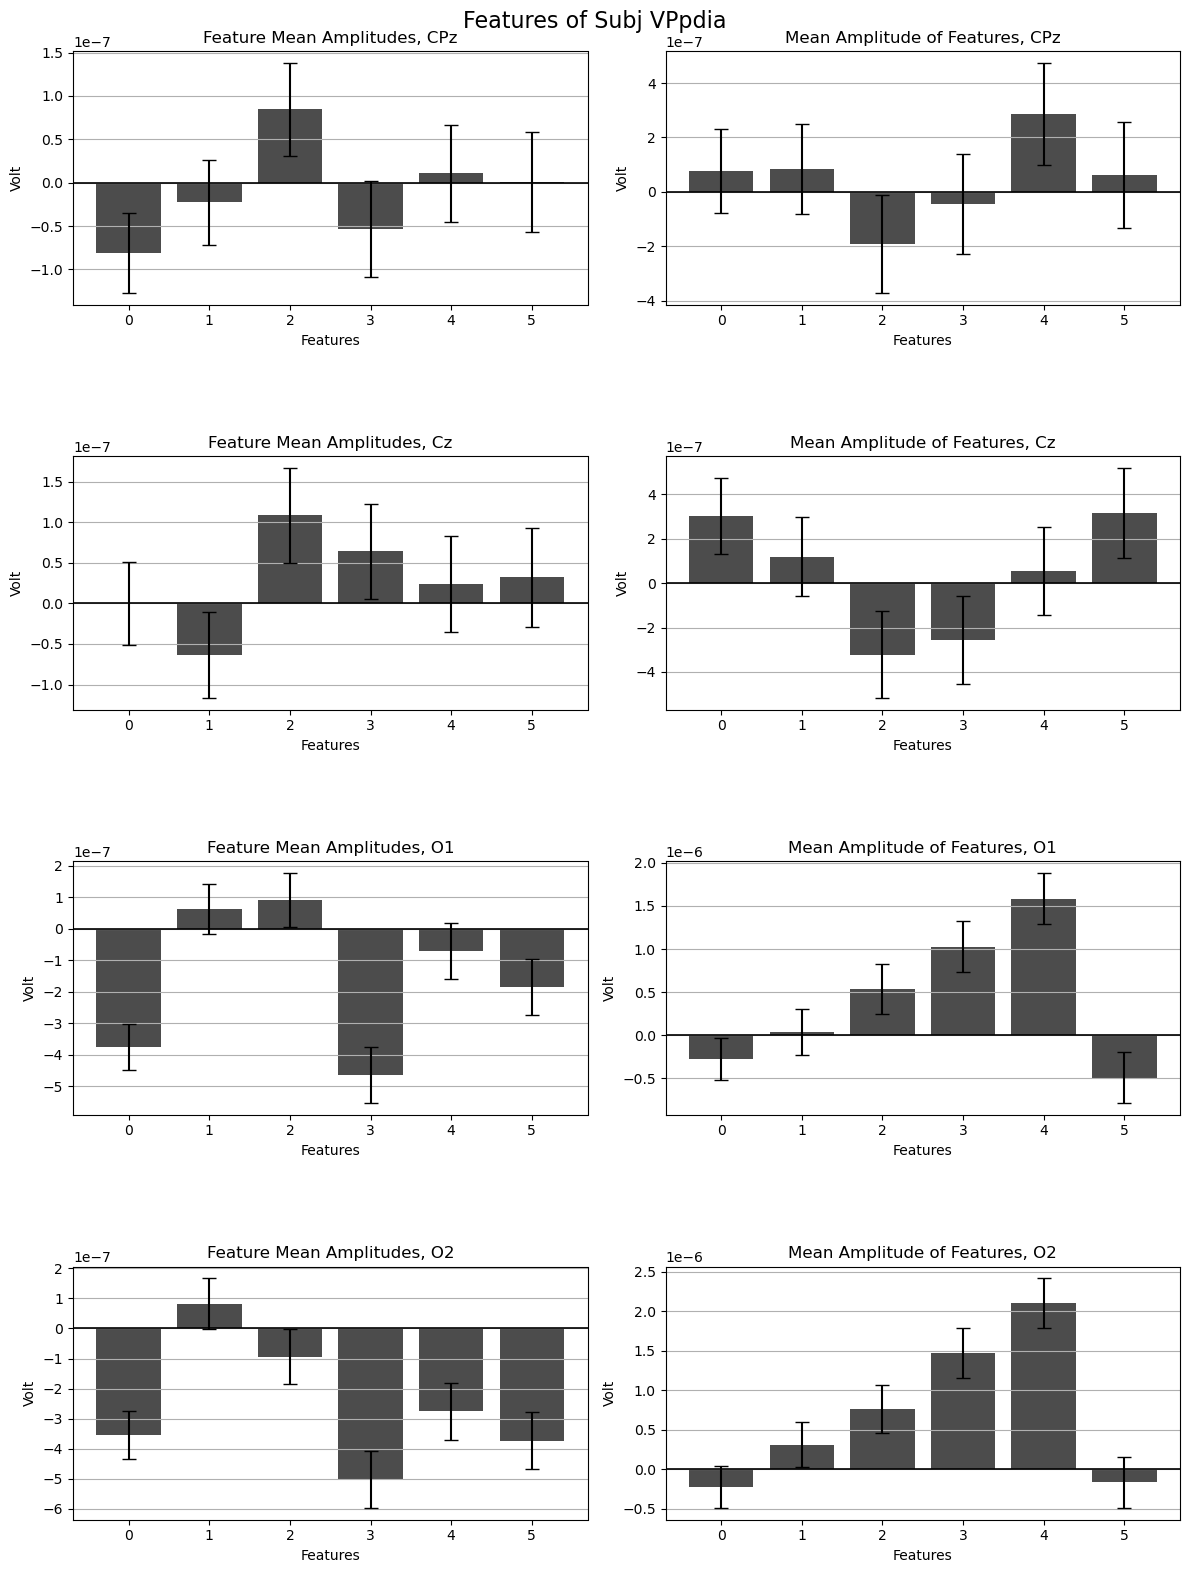

<Figure size 1200x1600 with 0 Axes>

In [9]:
import numpy as np
import os
from os.path import join
import numpy as np
import mne
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
mne.set_log_level('warning')
 # Data directory
task = "covert"      # Example task

# Define directories
wd = r'C:\Users\Radovan\OneDrive\Radboud\Studentships\Jordy Thielen\root'
os.chdir(wd)
data_dir = join(wd, "data")
experiment_dir = join(data_dir, "experiment")
files_dir = join(experiment_dir, 'files')
sourcedata_dir = join(experiment_dir, 'sourcedata')
derivatives_dir = join(join(experiment_dir, 'derivatives'))

analysis_dir = join(data_dir, "analysis")
p300_dir = join(analysis_dir, "p300")
features_dir = join(p300_dir, "plots", "features")


picks_hubner = [
    "F7", "F3", "Fz", "F4", "F8", "FC1", "FC2", "FC5", "FC6", "FCz", "T7", "C3", 
    "Cz", "C4", "T8", "CP1", "CP2", "CP5", "CP6", "CPz",
    "P7", "P3", "Pz", "P4", "P8", "Oz", "O1", "O2"
]
subjects = ["VPpdia", "VPpdib", "VPpdic", "VPpdid", "VPpdie", "VPpdif", "VPpdig", "VPpdih", "VPpdii", "VPpdij",
            "VPpdik", "VPpdil", "VPpdim", "VPpdin", "VPpdio", "VPpdip", "VPpdiq", "VPpdir", "VPpdis", "VPpdit",
            "VPpdiu", "VPpdiv", "VPpdiw", "VPpdix", "VPpdiy", "VPpdiz", "VPpdiza", "VPpdizb", "VPpdizc"]
subjects_channel_reject = {
    "VPpdib" : "FC2",
    "VPpdih" : "C3",
    "VPpdizb" : "Fz", 
    "VPpdizc": "FC2"
}

# Define which channels to visualize
channels_to_plot = ['CPz', 'Cz', 'O1', 'O2']
ch_names_probe = picks_hubner

for subject in subjects:
    # Load the NPZ file
    file_dir = os.path.join(derivatives_dir, 'preprocessed', "p300", f"sub-{subject}")
    file_path = os.path.join(file_dir, f"sub-{subject}_task-{task}_p300.npz") # Change data to load  
    npz_data = np.load(file_path)

    # Extract data from the npz object
    X = npz_data['X']  # EEG data: trials x channels x samples
    y = npz_data['y']  # Labels indicating cued side: trials
    z = npz_data['z']  # Left and right targets: trials x epochs x sides
    fs = npz_data['fs']  # Sampling frequency
    
    # Define periods for feature extraction
    ToI = [(30, 38), (38, 48), (48, 57), (57, 69), (69, 87), (87, 108)]
    
    y_matrix = compute_target_matrix(y, z)
    X_matrix, _ = extract_epochs(X, amplitude_threshold=40e-6)
    feature_matrix = extract_features_from_X(X_matrix)

    nontarget_data, sem_nontarget, target_data, sem_target = segment_X(X_matrix, y_matrix)
    average_nontarget_feat, sd_nontarget_feat, average_target_feat, sd_target_feat = segment_X(feature_matrix, y_matrix=y_matrix)
    feature_matrix = extract_features_from_X(X_matrix)


    save_dir = join(features_dir, subject)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    plot_features_sets(average_nontarget_feat, average_target_feat, sd_nontarget_feat, sd_target_feat,subjects_channel_reject = subjects_channel_reject,
                        ch_names=ch_names_probe, plot_channels=channels_to_plot,  save_dir=save_dir, subject=subject)

    plot_ERPs(nontarget_data, sem_nontarget, target_data, sem_target,ch_names=picks_hubner, channels_to_plot= channels_to_plot,
               subjects_channel_reject = subjects_channel_reject, subject=subject, save_dir=save_dir, show_bins=True)